In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import statsmodels.api as sm
import regionmask
from scipy import stats

In [9]:
def get_map(da,sgmap=None):
    if not sgmap:
        sgmap=xr.open_dataset('sgmap.nc')
    return da.sel(gridcell=sgmap.cclass).where(sgmap.notnan).compute()

In [41]:
def top_n(da,nx):
    ''' return top_n by param effect '''
    dx=abs(da.sel(minmax='max')-da.sel(minmax='min'))
    ix=dx.argsort()[-nx:].values
    x=da.isel(param=ix)
    return x
def rank_plot(da,nx,ax=None):
    x = top_n(da,nx)
    xdef = da.sel(param='default',minmax='min')
    
    if not ax:
        fig=plt.figure()
        ax=fig.add_subplot()
    
    ax.plot([xdef,xdef],[0,nx-1],'k:',label='default')
    ax.scatter(x.sel(minmax='min'),range(nx),marker='o',facecolors='none', edgecolors='r',label='low-val')
    ax.plot(x.sel(minmax='max'),range(nx),'ro',label='high-val')

    i=-1
    for xmin,xmax in x:
        i+=1
        ax.plot([xmin,xmax],[i,i],'r')
    ax.set_yticks(range(nx))
    ax.set_yticklabels([p[:15] for p in x.param.values])

In [16]:
f='/glade/u/home/djk2120/ppe_clean/postp/OAAT_surv.nc'
ds=xr.open_dataset(f)
f='/glade/u/home/djk2120/ppe_clean/pyth/clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sg=xr.open_dataset(f)
la=sg.area*sg.landfrac
la.name='Land Area'
la.attrs={'units':sg.area.attrs['units']}

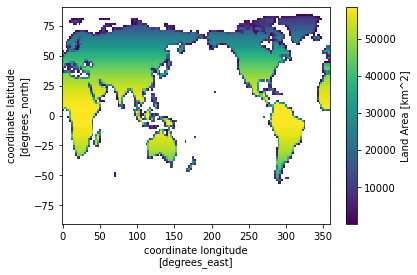

In [18]:
la.plot();

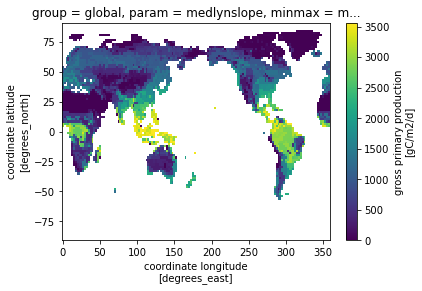

In [19]:
gpp=ds.GPP_gridded_mean.sel(exp='CTL2010',param='medlynslope',minmax='min')
get_map(gpp).plot();

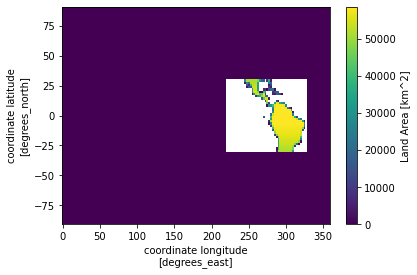

In [32]:
#set up tropical america subset
lasub=la.copy(deep=True)
ixlat=(sg.lat<-30)|(sg.lat>30)
ixlon=(sg.lon<220)|(sg.lon>328)
lasub[ixlat,:]=0
lasub[:,ixlon]=0
lasub.plot();

In [42]:
gpp_grid=get_map(ds.GPP_gridded_mean.sel(exp='CTL2010'))
gpp_america=1e-9*(lasub*gpp_grid).sum(dim=['lat','lon']).compute()

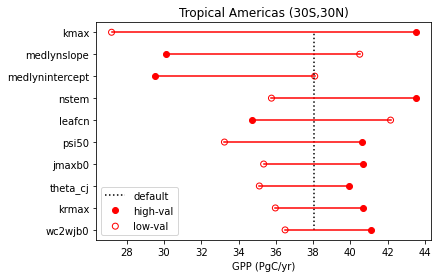

In [50]:
rank_plot(gpp_america,10)
plt.legend();
plt.xlabel('GPP (PgC/yr)')
plt.title('Tropical Americas (30S,30N)');